In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [4]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # 판별기 생성 및 컴파일
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # 생성기 생성
        self.generator = self.build_generator()

        # 생성기는 noise와 label을 입력으로 받음
        # label에 맞는 이미지를 생성함
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,)) 
        img = self.generator([noise, label])

        # 합쳐진 모델에서 생성기만 학습
        self.discriminator.trainable = False

        # 생성기는 label과 fake img를 받고 validity 출력
        valid = self.discriminator([img, label])

        # 합쳐진 모델(stacked generator and discriminator)
        # 판별기 속이기 위해 생성기 학습
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label)) # ?

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if epoch % 50 ==0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)              

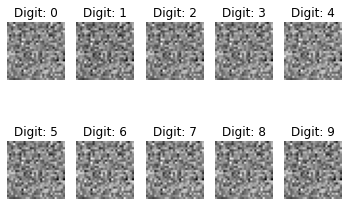

50 [D loss: 0.031885, acc.: 98.44%] [G loss: 4.155232]
100 [D loss: 0.140059, acc.: 96.88%] [G loss: 6.827807]
150 [D loss: 0.182088, acc.: 90.62%] [G loss: 5.888359]
200 [D loss: 0.258516, acc.: 87.50%] [G loss: 5.265526]


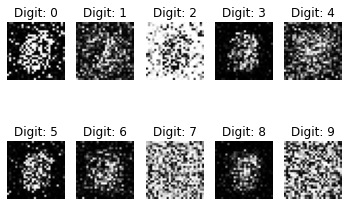

250 [D loss: 0.378664, acc.: 81.25%] [G loss: 3.783912]
300 [D loss: 0.278582, acc.: 89.06%] [G loss: 2.783359]
350 [D loss: 0.283487, acc.: 85.94%] [G loss: 3.018226]
400 [D loss: 0.412414, acc.: 79.69%] [G loss: 2.722394]


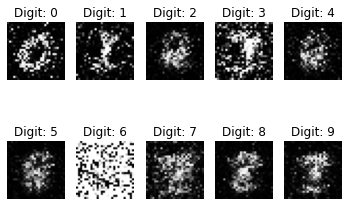

450 [D loss: 0.398423, acc.: 85.94%] [G loss: 2.356559]
500 [D loss: 0.345530, acc.: 85.94%] [G loss: 1.870054]
550 [D loss: 0.389749, acc.: 82.81%] [G loss: 1.862752]
600 [D loss: 0.541946, acc.: 73.44%] [G loss: 1.713971]


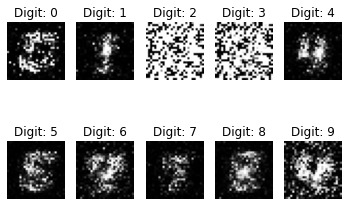

650 [D loss: 0.447801, acc.: 81.25%] [G loss: 1.763909]
700 [D loss: 0.407436, acc.: 76.56%] [G loss: 1.744699]
750 [D loss: 0.502640, acc.: 73.44%] [G loss: 1.696359]
800 [D loss: 0.586321, acc.: 70.31%] [G loss: 1.792154]


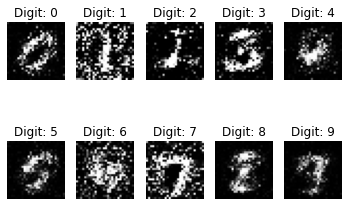

850 [D loss: 0.502306, acc.: 71.88%] [G loss: 1.733269]
900 [D loss: 0.462063, acc.: 78.12%] [G loss: 1.886942]
950 [D loss: 0.318219, acc.: 89.06%] [G loss: 1.634235]
1000 [D loss: 0.535143, acc.: 62.50%] [G loss: 1.474258]


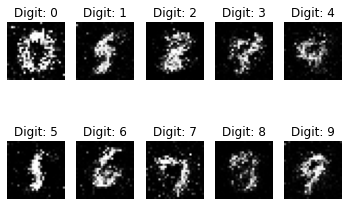

1050 [D loss: 0.577520, acc.: 76.56%] [G loss: 1.316370]
1100 [D loss: 0.619218, acc.: 59.38%] [G loss: 1.540909]
1150 [D loss: 0.689071, acc.: 60.94%] [G loss: 1.424518]
1200 [D loss: 0.522480, acc.: 70.31%] [G loss: 1.200304]


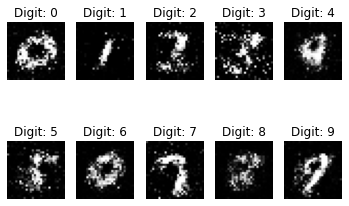

1250 [D loss: 0.591047, acc.: 67.19%] [G loss: 1.226583]
1300 [D loss: 0.622151, acc.: 68.75%] [G loss: 1.105171]
1350 [D loss: 0.673455, acc.: 60.94%] [G loss: 1.039742]
1400 [D loss: 0.602818, acc.: 64.06%] [G loss: 1.189640]


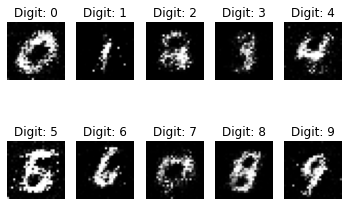

1450 [D loss: 0.567724, acc.: 73.44%] [G loss: 1.019930]
1500 [D loss: 0.618873, acc.: 64.06%] [G loss: 1.088242]
1550 [D loss: 0.578726, acc.: 70.31%] [G loss: 0.937346]
1600 [D loss: 0.663234, acc.: 59.38%] [G loss: 1.015333]


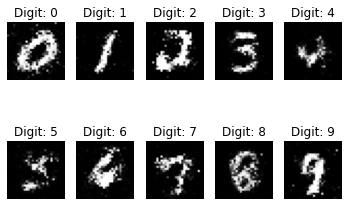

1650 [D loss: 0.645863, acc.: 62.50%] [G loss: 0.986337]
1700 [D loss: 0.658457, acc.: 60.94%] [G loss: 0.958134]
1750 [D loss: 0.613847, acc.: 67.19%] [G loss: 0.990108]
1800 [D loss: 0.700912, acc.: 50.00%] [G loss: 0.844037]


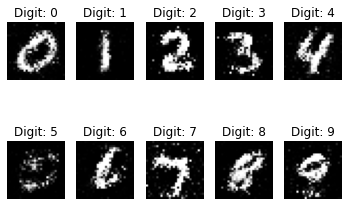

1850 [D loss: 0.717893, acc.: 46.88%] [G loss: 0.808812]
1900 [D loss: 0.675313, acc.: 60.94%] [G loss: 0.962500]
1950 [D loss: 0.658364, acc.: 64.06%] [G loss: 0.842354]
2000 [D loss: 0.678018, acc.: 54.69%] [G loss: 0.831691]


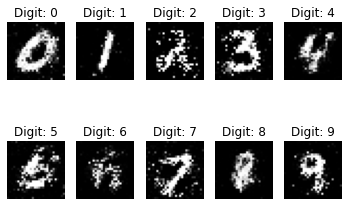

2050 [D loss: 0.662637, acc.: 64.06%] [G loss: 0.836429]
2100 [D loss: 0.652827, acc.: 62.50%] [G loss: 0.856678]
2150 [D loss: 0.641182, acc.: 59.38%] [G loss: 0.899454]
2200 [D loss: 0.707668, acc.: 54.69%] [G loss: 0.919169]


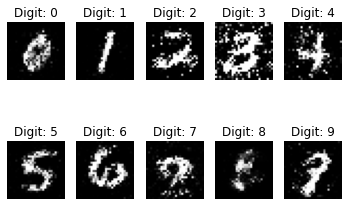

2250 [D loss: 0.656521, acc.: 65.62%] [G loss: 0.883989]
2300 [D loss: 0.673102, acc.: 53.12%] [G loss: 0.841652]
2350 [D loss: 0.647715, acc.: 57.81%] [G loss: 0.901565]
2400 [D loss: 0.663794, acc.: 54.69%] [G loss: 0.825656]


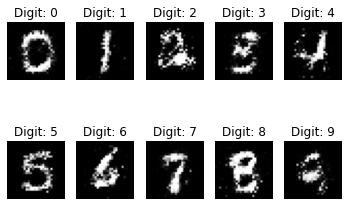

2450 [D loss: 0.680884, acc.: 60.94%] [G loss: 0.878103]
2500 [D loss: 0.656463, acc.: 56.25%] [G loss: 0.791975]
2550 [D loss: 0.684409, acc.: 51.56%] [G loss: 0.866896]
2600 [D loss: 0.663384, acc.: 56.25%] [G loss: 0.817008]


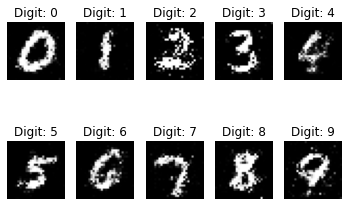

2650 [D loss: 0.691031, acc.: 48.44%] [G loss: 0.819749]
2700 [D loss: 0.696457, acc.: 42.19%] [G loss: 0.767180]
2750 [D loss: 0.658534, acc.: 59.38%] [G loss: 0.791491]
2800 [D loss: 0.629930, acc.: 67.19%] [G loss: 0.772115]


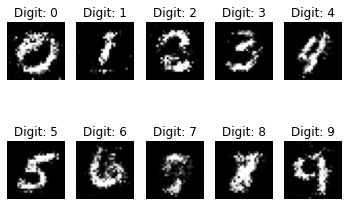

2850 [D loss: 0.699960, acc.: 57.81%] [G loss: 0.911648]
2900 [D loss: 0.650844, acc.: 68.75%] [G loss: 0.780475]
2950 [D loss: 0.687187, acc.: 57.81%] [G loss: 0.798031]
3000 [D loss: 0.629635, acc.: 60.94%] [G loss: 0.842366]


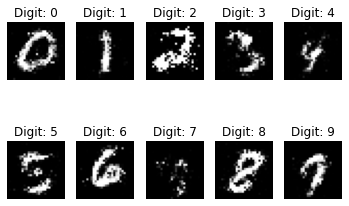

3050 [D loss: 0.679064, acc.: 51.56%] [G loss: 0.787938]
3100 [D loss: 0.697595, acc.: 59.38%] [G loss: 0.856099]
3150 [D loss: 0.659367, acc.: 59.38%] [G loss: 0.839816]
3200 [D loss: 0.674268, acc.: 46.88%] [G loss: 0.782502]


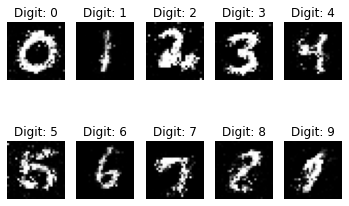

3250 [D loss: 0.721382, acc.: 48.44%] [G loss: 0.774917]
3300 [D loss: 0.627070, acc.: 59.38%] [G loss: 0.784924]
3350 [D loss: 0.699381, acc.: 50.00%] [G loss: 0.848133]
3400 [D loss: 0.648693, acc.: 60.94%] [G loss: 0.887038]


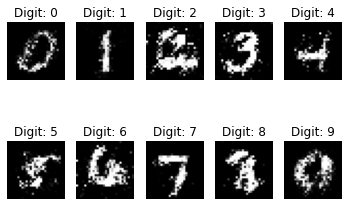

3450 [D loss: 0.680781, acc.: 54.69%] [G loss: 0.835082]
3500 [D loss: 0.688648, acc.: 56.25%] [G loss: 0.868588]
3550 [D loss: 0.649484, acc.: 50.00%] [G loss: 0.858315]
3600 [D loss: 0.712213, acc.: 53.12%] [G loss: 0.842921]


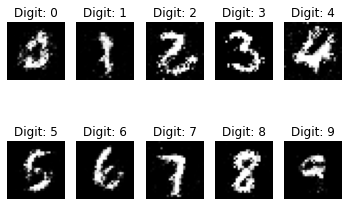

3650 [D loss: 0.660419, acc.: 62.50%] [G loss: 0.826110]
3700 [D loss: 0.652878, acc.: 56.25%] [G loss: 0.837139]
3750 [D loss: 0.677470, acc.: 57.81%] [G loss: 0.799138]
3800 [D loss: 0.713626, acc.: 50.00%] [G loss: 0.838905]


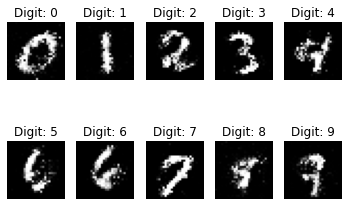

3850 [D loss: 0.623234, acc.: 64.06%] [G loss: 0.795488]
3900 [D loss: 0.679585, acc.: 53.12%] [G loss: 0.854182]
3950 [D loss: 0.757065, acc.: 53.12%] [G loss: 0.799804]
4000 [D loss: 0.696252, acc.: 54.69%] [G loss: 0.800232]


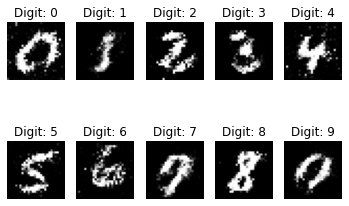

4050 [D loss: 0.661398, acc.: 62.50%] [G loss: 0.796558]
4100 [D loss: 0.668641, acc.: 65.62%] [G loss: 0.801024]
4150 [D loss: 0.688096, acc.: 53.12%] [G loss: 0.756846]
4200 [D loss: 0.666284, acc.: 62.50%] [G loss: 0.759079]


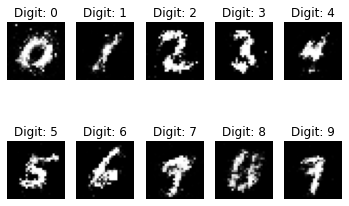

4250 [D loss: 0.646931, acc.: 70.31%] [G loss: 0.759324]
4300 [D loss: 0.701789, acc.: 51.56%] [G loss: 0.745217]
4350 [D loss: 0.665202, acc.: 54.69%] [G loss: 0.760355]
4400 [D loss: 0.669222, acc.: 68.75%] [G loss: 0.791390]


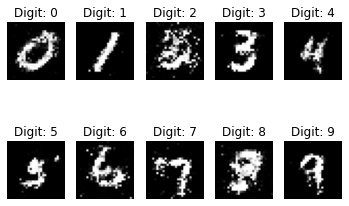

4450 [D loss: 0.718739, acc.: 54.69%] [G loss: 0.753454]
4500 [D loss: 0.688823, acc.: 54.69%] [G loss: 0.836071]
4550 [D loss: 0.682153, acc.: 57.81%] [G loss: 0.793550]
4600 [D loss: 0.645225, acc.: 60.94%] [G loss: 0.781538]


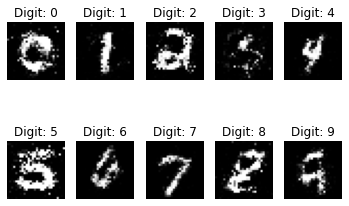

4650 [D loss: 0.638270, acc.: 65.62%] [G loss: 0.771087]
4700 [D loss: 0.686346, acc.: 46.88%] [G loss: 0.806148]
4750 [D loss: 0.666179, acc.: 54.69%] [G loss: 0.765457]
4800 [D loss: 0.631150, acc.: 75.00%] [G loss: 0.870281]


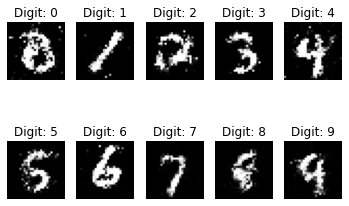

4850 [D loss: 0.703553, acc.: 46.88%] [G loss: 0.826908]
4900 [D loss: 0.707956, acc.: 42.19%] [G loss: 0.804269]
4950 [D loss: 0.681068, acc.: 59.38%] [G loss: 0.775568]
5000 [D loss: 0.697519, acc.: 50.00%] [G loss: 0.768519]


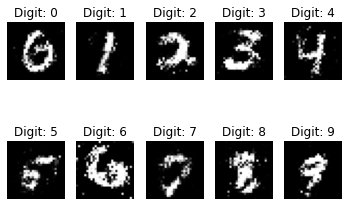

5050 [D loss: 0.692335, acc.: 48.44%] [G loss: 0.789898]
5100 [D loss: 0.670318, acc.: 56.25%] [G loss: 0.787839]
5150 [D loss: 0.699220, acc.: 54.69%] [G loss: 0.749085]
5200 [D loss: 0.695856, acc.: 48.44%] [G loss: 0.833070]


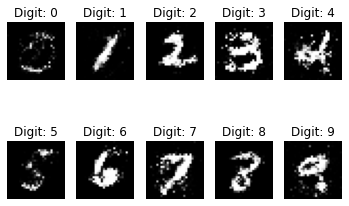

5250 [D loss: 0.680927, acc.: 56.25%] [G loss: 0.766048]
5300 [D loss: 0.658489, acc.: 62.50%] [G loss: 0.812443]
5350 [D loss: 0.724663, acc.: 48.44%] [G loss: 0.867383]
5400 [D loss: 0.670668, acc.: 56.25%] [G loss: 0.795262]


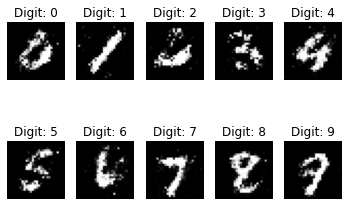

5450 [D loss: 0.719816, acc.: 45.31%] [G loss: 0.759242]
5500 [D loss: 0.675750, acc.: 56.25%] [G loss: 0.787228]
5550 [D loss: 0.685744, acc.: 51.56%] [G loss: 0.805231]
5600 [D loss: 0.661057, acc.: 65.62%] [G loss: 0.781208]


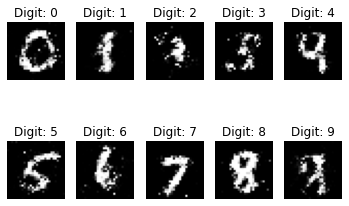

5650 [D loss: 0.704602, acc.: 48.44%] [G loss: 0.779700]
5700 [D loss: 0.676674, acc.: 57.81%] [G loss: 0.762598]
5750 [D loss: 0.651724, acc.: 64.06%] [G loss: 0.753609]
5800 [D loss: 0.682378, acc.: 56.25%] [G loss: 0.768384]


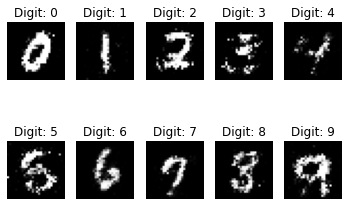

5850 [D loss: 0.726098, acc.: 42.19%] [G loss: 0.826454]
5900 [D loss: 0.668130, acc.: 54.69%] [G loss: 0.828667]
5950 [D loss: 0.674864, acc.: 62.50%] [G loss: 0.803529]
6000 [D loss: 0.631345, acc.: 60.94%] [G loss: 0.806773]


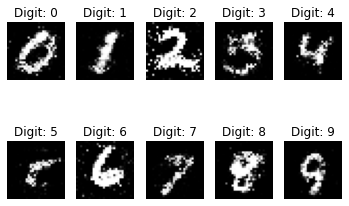

6050 [D loss: 0.708479, acc.: 45.31%] [G loss: 0.808673]
6100 [D loss: 0.693081, acc.: 53.12%] [G loss: 0.818659]
6150 [D loss: 0.641774, acc.: 54.69%] [G loss: 0.808537]
6200 [D loss: 0.695493, acc.: 46.88%] [G loss: 0.830288]


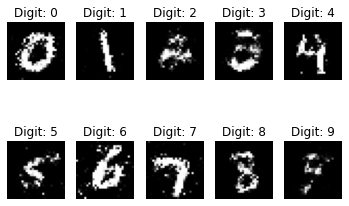

6250 [D loss: 0.659119, acc.: 57.81%] [G loss: 0.768757]
6300 [D loss: 0.665689, acc.: 57.81%] [G loss: 0.764682]
6350 [D loss: 0.779641, acc.: 45.31%] [G loss: 0.819989]
6400 [D loss: 0.684541, acc.: 54.69%] [G loss: 0.774345]


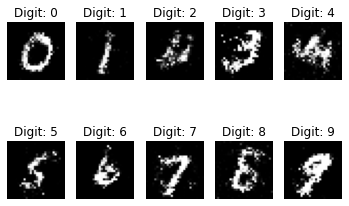

6450 [D loss: 0.687213, acc.: 56.25%] [G loss: 0.717560]
6500 [D loss: 0.673049, acc.: 59.38%] [G loss: 0.789737]
6550 [D loss: 0.640297, acc.: 56.25%] [G loss: 0.840776]
6600 [D loss: 0.743258, acc.: 46.88%] [G loss: 0.820852]


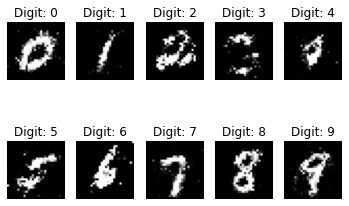

6650 [D loss: 0.654446, acc.: 60.94%] [G loss: 0.891492]
6700 [D loss: 0.616938, acc.: 65.62%] [G loss: 0.797109]
6750 [D loss: 0.648269, acc.: 56.25%] [G loss: 0.800125]
6800 [D loss: 0.656576, acc.: 59.38%] [G loss: 0.735792]


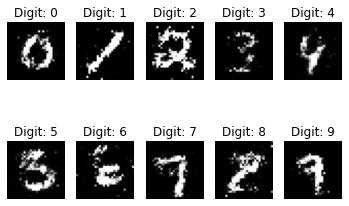

6850 [D loss: 0.633431, acc.: 62.50%] [G loss: 0.778280]
6900 [D loss: 0.689207, acc.: 56.25%] [G loss: 0.810216]
6950 [D loss: 0.621906, acc.: 64.06%] [G loss: 0.852808]
7000 [D loss: 0.646918, acc.: 54.69%] [G loss: 0.792588]


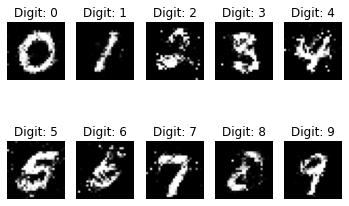

7050 [D loss: 0.673102, acc.: 51.56%] [G loss: 0.793386]
7100 [D loss: 0.658789, acc.: 51.56%] [G loss: 0.855894]
7150 [D loss: 0.622684, acc.: 65.62%] [G loss: 0.867521]
7200 [D loss: 0.625764, acc.: 65.62%] [G loss: 0.769922]


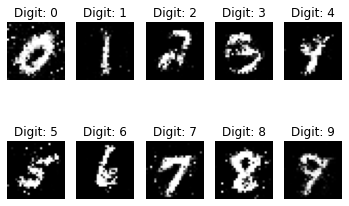

7250 [D loss: 0.705037, acc.: 53.12%] [G loss: 0.772099]
7300 [D loss: 0.691506, acc.: 46.88%] [G loss: 0.751052]
7350 [D loss: 0.664521, acc.: 57.81%] [G loss: 0.816296]
7400 [D loss: 0.640604, acc.: 62.50%] [G loss: 0.786165]


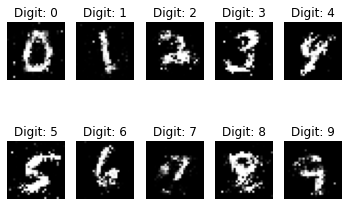

7450 [D loss: 0.690733, acc.: 48.44%] [G loss: 0.782134]
7500 [D loss: 0.652353, acc.: 60.94%] [G loss: 0.739453]
7550 [D loss: 0.672060, acc.: 56.25%] [G loss: 0.767483]
7600 [D loss: 0.645795, acc.: 57.81%] [G loss: 0.806109]


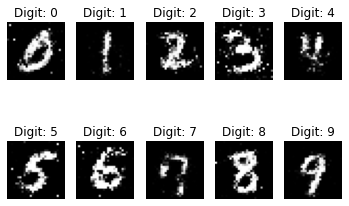

7650 [D loss: 0.677085, acc.: 54.69%] [G loss: 0.837537]
7700 [D loss: 0.652562, acc.: 53.12%] [G loss: 0.792808]
7750 [D loss: 0.640788, acc.: 62.50%] [G loss: 0.851901]
7800 [D loss: 0.656933, acc.: 62.50%] [G loss: 0.848663]


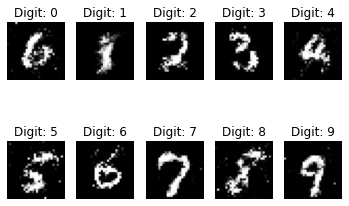

7850 [D loss: 0.639993, acc.: 68.75%] [G loss: 0.747745]
7900 [D loss: 0.644241, acc.: 62.50%] [G loss: 0.799244]
7950 [D loss: 0.657048, acc.: 64.06%] [G loss: 0.806475]
8000 [D loss: 0.640426, acc.: 62.50%] [G loss: 0.757029]


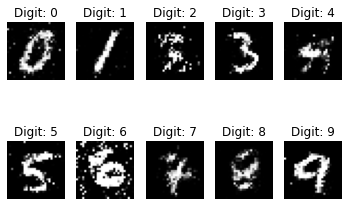

8050 [D loss: 0.594529, acc.: 62.50%] [G loss: 0.819582]
8100 [D loss: 0.646012, acc.: 57.81%] [G loss: 0.768186]
8150 [D loss: 0.712653, acc.: 51.56%] [G loss: 0.868086]
8200 [D loss: 0.713596, acc.: 48.44%] [G loss: 0.822663]


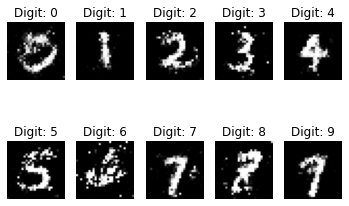

8250 [D loss: 0.638558, acc.: 67.19%] [G loss: 0.818472]
8300 [D loss: 0.654104, acc.: 59.38%] [G loss: 0.788042]
8350 [D loss: 0.668049, acc.: 54.69%] [G loss: 0.818645]
8400 [D loss: 0.652846, acc.: 48.44%] [G loss: 0.826402]


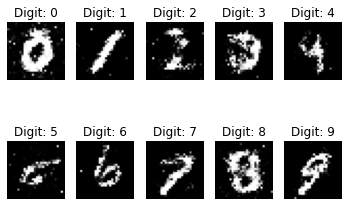

8450 [D loss: 0.654291, acc.: 62.50%] [G loss: 0.849567]
8500 [D loss: 0.709865, acc.: 48.44%] [G loss: 0.786569]
8550 [D loss: 0.656124, acc.: 56.25%] [G loss: 0.706967]
8600 [D loss: 0.695151, acc.: 48.44%] [G loss: 0.881253]


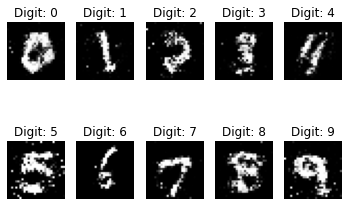

8650 [D loss: 0.716608, acc.: 46.88%] [G loss: 0.834667]
8700 [D loss: 0.670656, acc.: 57.81%] [G loss: 0.786677]
8750 [D loss: 0.674532, acc.: 53.12%] [G loss: 0.813375]
8800 [D loss: 0.658298, acc.: 57.81%] [G loss: 0.781494]


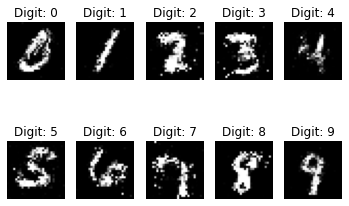

8850 [D loss: 0.592125, acc.: 68.75%] [G loss: 0.784976]
8900 [D loss: 0.642813, acc.: 62.50%] [G loss: 0.742087]
8950 [D loss: 0.703824, acc.: 51.56%] [G loss: 0.868693]
9000 [D loss: 0.690385, acc.: 53.12%] [G loss: 0.715113]


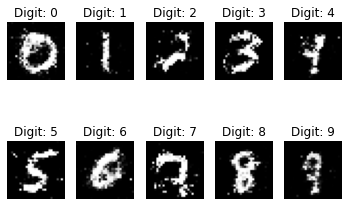

9050 [D loss: 0.623519, acc.: 64.06%] [G loss: 0.831770]
9100 [D loss: 0.674212, acc.: 60.94%] [G loss: 0.798968]


In [ ]:
if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=20000, batch_size=32, sample_interval=200)